# Projeto SuperComputação 2023.2

## Aluno: Guilherme Fontana Louro

# Introdução do problema

## Análise de Redes Sociais: encontrando a clique máxima em um grafo.

![Exemplo Clique](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png)


A análise de redes sociais (ARS) é uma abordagem oriunda de áreas tais como Sociologia, Psicologia Social e Antropologia. Tal abordagem estuda as ligações relacionais (*relational tie*) entre atores sociais. Os atores na ARS podem ser tanto pessoas e empresas, analisadas como unidades individuais, quanto unidades sociais coletivas como, por exemplo, departamentos dentro de uma organização, agências de serviço público em uma cidade, estados-nações de um continente, dentre outras. A ARS difere fundamentalmente de outros estudos pelo fato de que sua ênfase não é nos atributos (características) dos atores, mas nas ligações entre eles.


A idéia de uma clique em um grafo é relativamente simples. No nível mais geral, uma clique é um subconjunto de uma rede no qual os atores são mais próximos entre si do que com outros membros da rede. Em termo de laços de amizade, por exemplo, não é incomum encontrar grupos humanos que formam cliques baseando-se em idade, gênero, raça, etnia, religião, ideologia, e muitas coisas coisas. Uma clique é, portanto, um conjunto de vértices em um grafo em que cada par de vértices está diretamente conectado por uma aresta.

Encontrar a clique máxima em um grafo é uma tarefa computacionalmente desafiadora devido à natureza combinatória do problema.  A dificuldade computacional surge da necessidade de explorar todas as combinações possíveis de vértices para identificar a maior clique, o que se torna exponencial em relação ao número de vértices. Isso resulta em uma complexidade computacional alta, mesmo para grafos moderadamente grandes.

A importância de estudar cliques está notavelmente presente na análise de redes sociais, onde as cliques representam grupos coesos de indivíduos que compartilham interesses, amizades ou conexões em comum. A identificação de cliques ajuda a entender a estrutura de uma rede social, identificar influenciadores e grupos de afinidade, além de auxiliar na detecção de comunidades e na análise de dinâmicas sociais.

As cliques são importantes, pois além de desenvolver em seus membros comportamentos homogêneos, elas têm, por definição, grande proximidade, aumentando a velocidade das trocas. Assim, informações dirigidas a uma clique são rapidamente absorvidas pelos seus membros, que tendem a percebê-las de forma semelhante. Isso é importante, por exemplo, em estratégias de segmentação.


Portanto, a resolução eficiente do problema da clique máxima tem aplicações valiosas em áreas que vão desde a ciência da computação até a análise de dados em redes sociais.

# IMPORTANTE: 

### Todos os códigos que serão vistos a seguir podem rodar neste notebook, mas para otimização do projeto, foi utilizado o computador pessoal do aluno e o cluster da disciplina para fazer todas as iterações, assim como consta na rubrica. Caso desejado acompanhar o código, pode ser incluido o comando %%writefile nome_do_arquivo.cpp no inicio da célula, e o código será salvo no diretório atual. Para compilar o código, foram utilizado os comandos vistos em aula: 
  - g++ -Wall -O3 -fopenmp -g 1-exaustiva.cpp -o exaustiva
  - ./exaustiva
  - g++ -Wall -O3 -fopenmp -g 2-ThreadsOpenMP.cpp -o OpenMP
  - ./OpenMP
  - mpic++ -o mpi 3-ImplementacaoMPI.cpp
  - sbatch mpi.slurm

1. **Abordagem Exaustiva**

A exaustão é uma abordagem que seleciona iterativamente os vértices para formar um clique, geralmente começando com um vértice e adicionando outros que tenham o maior número de vizinhos já na clique. Aqui está um pseudo-código simplificado para detectar cliques em um grafo usando essa abordagem. ATENÇÃO: esse pseudo-codigo **não** é a solução completa dessa abordagem. Você pode se inspirar nele para compreender como resolver o problema, mas é parte de sua tarefa desenvolver a solução.

Implemente o código em C++.

### Pseudo-código fornecido pelo professor

```
Função EncontrarCliqueMaxima(grafo, numVertices)
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()  # Inicialmente, todos os nós são candidatos

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar for Verdadeiro Então
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos for Verdadeiro Então
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            candidatos = novosCandidatos
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função
```


Aproveite para pensar se é possível adotar alguma heurística. Por exemplo, ordenar os nós em função do grau de adjacência, ajuda?


**Sua segunda tarefa**: Até qual tamanho de problema você conseguiu obter um resultado em tempo hábil (aprox. 15 min)? Você deve apresentar um pseudo-codigo de uma heurística para otimizar essa tarefa exaustiva. É possível implementar alguma poda? Algum critério que evite calcular um nó, dado que você já descobriu uma clique maior?

In [ ]:
#include <algorithm>
#include <fstream>
#include <iostream>
#include <omp.h>
#include <vector>
#include "ReadGraph.cpp"

// Function to check if a node belongs to the clique
std::tuple<std::vector<int>, std::vector<int>> CliqueCheck(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique,
    int vertex) {
    std::vector<int> newCandidates = candidates;
    newCandidates.erase(std::remove(newCandidates.begin(), newCandidates.end(), vertex), newCandidates.end());

    bool canAdd = true;
    for (int u : currentClique) {
        if (graph[u][vertex] == 0) {
            canAdd = false;
            break;
        }
    }

    std::vector<int> newClique = currentClique;
    if (canAdd) {
        newClique.push_back(vertex);

        std::vector<int> updatedCandidates;
        for (int u : newCandidates) {
            bool adjacentToAll = true;
            for (int c : newClique) {
                if (graph[u][c] == 0) {
                    adjacentToAll = false;
                    break;
                }
            }
            if (adjacentToAll) {
                updatedCandidates.push_back(u);
            }
        }
        newCandidates = updatedCandidates;
    }

    return std::make_tuple(newClique, newCandidates);
}

// Function to find the maximum clique in a graph
std::vector<int> FindMaximumClique(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique) {
    std::vector<int> maximumClique = currentClique;

    for (int candidate : candidates) {
        std::vector<int> newCandidates;
        std::vector<int> newClique;
        std::tie(newClique, newCandidates) = CliqueCheck(graph, candidates, currentClique, candidate);

        if (!newCandidates.empty()) {
            newClique = FindMaximumClique(graph, newCandidates, newClique);
        }

        if (newClique.size() >= maximumClique.size()) {
            maximumClique = newClique;
        }
    }

    return maximumClique;
}

int main() {
    int numVertices = 45;
    std::vector<std::vector<int>> graph;
    graph = ReadGraph("grafo.txt", numVertices);

    std::vector<int> allVertices;
    for (int i = 0; i < numVertices; ++i) {
        allVertices.push_back(i);
    }

    std::vector<int> initialClique;

    double startTime = omp_get_wtime();

    std::vector<int> maximumClique = FindMaximumClique(graph, allVertices, initialClique);

    double duration = omp_get_wtime() - startTime;

    std::cout << "Maximum clique: ";
    for (int u : maximumClique) {
        std::cout << u + 1 << " ";
    }
    std::cout << std::endl;

    std::cout << "Duration: " << duration << " s";

    return 0;
}


## Sua segunda tarefa: 
Até qual tamanho de problema você conseguiu obter um resultado em tempo hábil (aprox. 15 min)? Você deve apresentar um pseudo-codigo de uma heurística para otimizar essa tarefa exaustiva. É possível implementar alguma poda? Algum critério que evite calcular um nó, dado que você já descobriu uma clique maior?

## Resposta:
Consegui resolver o problema para grafos de até 45 vértices em tempo hábil, no caso, 316s. Para grafos maiores, o tempo de execução é muito alto, inviabilizando a resolução do problema.
O resultado desse teste pode ser visto na imagem abaixo, que mostra o tempo de execução para grafos de 45 vértices e demonstra que o resultado é obtido em menos de 15 minutos e é igual ao retornado pelo arquivo fornecido verifica_max.py.

![Resultado](imgs/resultado.png)

Sobre a implementação de alguma poda, é possível realizar uma técnica conhecida como poda por limites(pruining by bounds), que consiste em utilizar o tamanho da maior clique já encontrada. Se o tamanho da clique atual, somado ao número de vértices restantes, for menor que o tamanho da maior clique já encontrada, então não é necessário continuar a busca, pois não será possível encontrar uma clique maior que a já encontrada.

A poda por limites ajuda a reduzir o número de ramos explorados, economizando tempo computacional.


### Pseudo-código da solução:

```
Função EncontrarCliqueMaxima(grafo, numVertices)
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()  # Inicialmente, todos os nós são candidatos

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar for Verdadeiro Então
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos for Verdadeiro Então
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            # Poda por limites
            Se tamanho(cliqueMaxima) + tamanho(novosCandidatos) >= tamanho(cliqueMaxima) Então
                candidatos = novosCandidatos
            Senão
                Parar a exploração desse ramo
            Fim Se
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função
```

## Implementação

Na célula abaixo, foi implementado o código em C++ para a solução do problema com a implementação da poda por limites.

In [ ]:
#include <algorithm>
#include <fstream>
#include <iostream>
#include <omp.h>
#include <vector>
#include "ReadGraph.cpp"

// Function to check if a vertex belongs to the clique
std::tuple<std::vector<int>, std::vector<int>> CliqueCheck(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique,
    int vertex) {
    std::vector<int> newCandidates = candidates;
    newCandidates.erase(std::remove(newCandidates.begin(), newCandidates.end(), vertex), newCandidates.end());

    bool canAdd = true;
    for (int u : currentClique) {
        if (graph[u][vertex] == 0) {
            canAdd = false;
            break;
        }
    }

    std::vector<int> newClique = currentClique;
    if (canAdd) {
        newClique.push_back(vertex);

        std::vector<int> updatedCandidates;
        for (int u : newCandidates) {
            bool adjacentToAll = true;
            for (int c : newClique) {
                if (graph[u][c] == 0) {
                    adjacentToAll = false;
                    break;
                }
            }
            if (adjacentToAll) {
                updatedCandidates.push_back(u);
            }
        }
        newCandidates = updatedCandidates;
    }

    return std::make_tuple(newClique, newCandidates);
}

// Function to find the maximum clique in a graph with pruning by bounds
std::vector<int> FindMaximumCliqueWithPruining(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique,
    std::vector<int> &maximumClique) {
    if (candidates.empty()) {
        if (currentClique.size() > maximumClique.size()) {
            maximumClique = currentClique;
        }
        return maximumClique;
    }

    // Poda por limites
    if (currentClique.size() + candidates.size() <= maximumClique.size()) {
        return maximumClique;
    }

    for (int candidate : candidates) {
        std::vector<int> newCandidates;
        std::vector<int> newClique;
        std::tie(newClique, newCandidates) = CliqueCheck(graph, candidates, currentClique, candidate);

        if (!newCandidates.empty()) {
            newClique = FindMaximumCliqueWithPruining(graph, newCandidates, newClique, maximumClique);
        }

        if (newClique.size() >= maximumClique.size()) {
            maximumClique = newClique;
        }
    }

    return maximumClique;
}

int main() {
    int numVertices = 45;
    std::vector<std::vector<int>> graph;
    graph = ReadGraph("grafo.txt", numVertices);

    std::vector<int> allVertices;
    for (int i = 0; i < numVertices; ++i) {
        allVertices.push_back(i);
    }

    std::vector<int> initialClique;
    std::vector<int> maximumClique;

    double startTime = omp_get_wtime();

    maximumClique = FindMaximumCliqueWithPruining(graph, allVertices, initialClique, maximumClique);

    double duration = omp_get_wtime() - startTime;

    std::cout << "Maximum clique: ";
    for (int u : maximumClique) {
        std::cout << u + 1 << " ";
    }
    std::cout << std::endl;

    std::cout << "Duration: " << duration << " s";

    return 0;
}


2. **Implementação com Threads OpenMP**

A implementação de uma solução com OpenMP para encontrar cliques em um grafo usando a heurística gulosa envolve a paralelização das iterações do algoritmo em diferentes threads. O OpenMP simplifica a criação de threads e a coordenação entre elas.


Nessa implementação você deve apresentar o código-fonte modificado, justificar a alteração feita, e mostrar também o speed up obtido. Faça uso de gráficos e tabelas para mostrar que sua implementação em openMP valeu a pena. Observe que mesmo assim você não vai conseguir resolver exaustivamente o problema, mas o tamanho do grafo será maior, e o tempo de processamento para um mesmo tamanho deve ser preferencialmente menor.

In [ ]:
#include "ReadGraph.cpp"
#include <algorithm>
#include <fstream>
#include <iostream>
#include <omp.h>
#include <tuple>
#include <vector>

// Function to check if a node belongs to the clique
std::tuple<std::vector<int>, std::vector<int>> CliqueCheck(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique,
    int vertex) {
    std::vector<int> newCandidates = candidates;
    newCandidates.erase(std::remove(newCandidates.begin(), newCandidates.end(), vertex), newCandidates.end());

    bool canAdd = true;
    for (int u : currentClique) {
        if (graph[u][vertex] == 0) {
            canAdd = false;
            break;
        }
    }

    std::vector<int> newClique = currentClique;
    if (canAdd) {
        newClique.push_back(vertex);

        std::vector<int> updatedCandidates;
        #pragma omp parallel for
        for (int u : newCandidates) {
            bool adjacentToAll = true;
            for (int c : newClique) {
                if (graph[u][c] == 0) {
                    adjacentToAll = false;
                    break;
                }
            }
            if (adjacentToAll) {
                updatedCandidates.push_back(u);
            }
        }
        newCandidates = updatedCandidates;
    }

    return std::make_tuple(newClique, newCandidates);
}

// Function to find the maximum clique in a graph
std::vector<int> FindMaximumClique(
    const std::vector<std::vector<int>> &graph,
    const std::vector<int> &candidates,
    const std::vector<int> &currentClique) {
    std::vector<int> maximumClique = currentClique;

    // Poda por limites
    if (currentClique.size() + candidates.size() <= maximumClique.size()) {
        return maximumClique;
    }

    #pragma omp parallel for
    for (int candidate : candidates) {
        std::vector<int> newCandidates;
        std::vector<int> newClique;
        std::tie(newClique, newCandidates) = CliqueCheck(graph, candidates, currentClique, candidate);

        if (!newCandidates.empty()) {
            newClique = FindMaximumClique(graph, newCandidates, newClique);
        }

        if (newClique.size() >= maximumClique.size()) {
            maximumClique = newClique;
        }
    }

    return maximumClique;
}

int main() {
    int numVertices = 45;
    std::vector<std::vector<int>> graph;
    graph = ReadGraph("grafo.txt", numVertices);

    std::vector<int> allVertices;
    for (int i = 0; i < numVertices; ++i) {
        allVertices.push_back(i);
    }

    std::vector<int> initialClique;

    double startTime = omp_get_wtime();

    std::vector<int> maximumClique = FindMaximumClique(graph, allVertices, initialClique);

    double duration = omp_get_wtime() - startTime;

    std::cout << "Maximum clique: ";
    for (int u : maximumClique) {
        std::cout << u + 1 << " ";
    }
    std::cout << std::endl;

    std::cout << "Duration: " << duration << " s";

    return 0;
}


Nessa iteração, foi adicionado o código #pragma omp parallel for para paralelizar o loop mais externo do algoritmo, que é o que percorre os vértices do grafo. Além disso, foi adicionado o #pragma omp parallel for para paralelizar o loop que percorre os candidatos a vértices da clique. No final deste notebook, é possível ver o gráfico de speedup obtido com a implementação do OpenMP.


3. **Paralelização e Distribuição do Processamento com MPI**

Nesta implementação, você deve dividir o problema em várias partes e distribuí-las para diferentes processadores usando a biblioteca MPI (*Message Passing Interface*). Cada processador será responsável por encontrar cliques em uma parte do grafo, e os resultados serão combinados no final para encontrar todas as cliques no grafo.

In [ ]:
#include <algorithm>
#include <fstream>
#include <iostream>
#include <mpi.h>
#include <vector>
#include "ReadGraph.cpp"

using namespace std;

tuple<vector<int>, vector<int>> CliqueCheck(
    const vector<vector<int>> &graph,
    const vector<int> &candidates,
    const vector<int> &currentClique,
    int vertex) {
    vector<int> newCandidates = candidates;
    newCandidates.erase(remove(newCandidates.begin(), newCandidates.end(), vertex), newCandidates.end());

    bool canAdd = true;
    for (int u : currentClique) {
        if (graph[u][vertex] == 0) {
            canAdd = false;
            break;
        }
    }

    vector<int> newClique = currentClique;
    if (canAdd) {
        newClique.push_back(vertex);

        vector<int> updatedCandidates;
        for (int u : newCandidates) {
            bool adjacentToAll = true;
            for (int c : newClique) {
                if (graph[u][c] == 0) {
                    adjacentToAll = false;
                    break;
                }
            }
            if (adjacentToAll) {
                updatedCandidates.push_back(u);
            }
        }
        newCandidates = updatedCandidates;
    }

    return make_tuple(newClique, newCandidates);
}

vector<int> FindMaximumClique(
    const vector<vector<int>> &graph,
    const vector<int> &candidates,
    const vector<int> &currentClique) {
    vector<int> maximumClique = currentClique;

    // Poda por limites
    if (currentClique.size() + candidates.size() <= maximumClique.size()) {
        return maximumClique;
    }

    for (int candidate : candidates) {
        vector<int> newCandidates;
        vector<int> newClique;
        tie(newClique, newCandidates) = CliqueCheck(graph, candidates, currentClique, candidate);

        if (!newCandidates.empty()) {
            newClique = FindMaximumClique(graph, newCandidates, newClique);
        }

        if (newClique.size() >= maximumClique.size()) {
            maximumClique = newClique;
        }
    }

    return maximumClique;
}

int main(int argc, char **argv) {

    int numVertices = 45;
    vector<vector<int>> graph;

    graph = ReadGraph("grafo_gerado.txt", numVertices);

    vector<int> candidates;
    for (int i = 0; i <= numVertices - 1; i++) {
        candidates.push_back(i);
    }

    int i;
    MPI_Status status;
    int myStart = 0, myEnd = 0;
    int candPerProc = 0;
    vector<int> MaximumClique;
    vector<int> PartialMaximumClique;
    vector<int> MaximumCliqueSizeVector;
    int MaximumCliqueSize;
    int size;

    MPI_Init(&argc, &argv);
    int rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    if (rank == 0) {
        candPerProc = candidates.size() / size;
        for (i = 1; i < size; i++) {
            MPI_Send(&candPerProc, 1, MPI_INT, i, 0, MPI_COMM_WORLD);
        }
    } else {
        MPI_Recv(&candPerProc, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
    }

    myStart = rank * candPerProc;
    myEnd = myStart + candPerProc;
    for (i = myStart; i < myEnd; i++) {
        vector<int> newCandidates;
        vector<int> newClique;
        tie(newClique, newCandidates) = CliqueCheck(graph, candidates, newClique, i);

        if (!newCandidates.empty()) {
            newClique = FindMaximumClique(graph, newCandidates, newClique);
        }

        if (newClique.size() >= MaximumClique.size()) {
            MaximumClique = newClique;
        }
    }

    if (rank != 0) {
        MaximumCliqueSize = MaximumClique.size();
        MPI_Send(&MaximumCliqueSize, 1, MPI_INT, 0, 0, MPI_COMM_WORLD);
    } else {
        for (i = 1; i < size; i++) {
            MPI_Recv(&MaximumCliqueSize, 1, MPI_INT, i, 0, MPI_COMM_WORLD, &status);
            MaximumCliqueSizeVector.push_back(MaximumCliqueSize);
        }
    }

    if (rank != 0) {
        MPI_Send(&MaximumClique[0], MaximumClique.size(), MPI_INT, 0, 0, MPI_COMM_WORLD);
    } else {
        for (i = 1; i < size; i++) {
            PartialMaximumClique.resize(MaximumCliqueSizeVector[i - 1]);
            MPI_Recv(&PartialMaximumClique[0], PartialMaximumClique.size(), MPI_INT, i, 0, MPI_COMM_WORLD, &status);
            if (PartialMaximumClique.size() >= MaximumClique.size()) {
                MaximumClique = PartialMaximumClique;
            }
        }
        sort(MaximumClique.begin(), MaximumClique.end());
        cout << "Maximum clique size: " << MaximumClique.size() << endl;
        cout << "Maximum clique: "
             << ": [";
        for (auto &v : MaximumClique) {
            if (&v == &MaximumClique.back()) {
                cout << v + 1;
            } else {
                cout << v + 1 << ", ";
            }
        }
        cout << "]" << endl;
    }

    MPI_Finalize();
    return 0;
}


# Arquivo .slurm para submissão no cluster

In [ ]:
#!/bin/bash
#SBATCH --nodes=2               # Número de nós
#SBATCH --ntasks-per-node=3     # Número de tarefas por nó (CPUs por nó)
#SBATCH --cpus-per-task=1       # Número de CPUs por tarefa
#SBATCH --partition=normal

mpirun --allow-run-as-root -np 2 ./mpi

## Como apresentar seus resultados


Você deverá focar em comparar suas implementações em relação ao speedup. Aumente o tamanho do grafo e das arestas, e busque determinar a clique máxima.

# Resultados

## Implementação Exaustiva

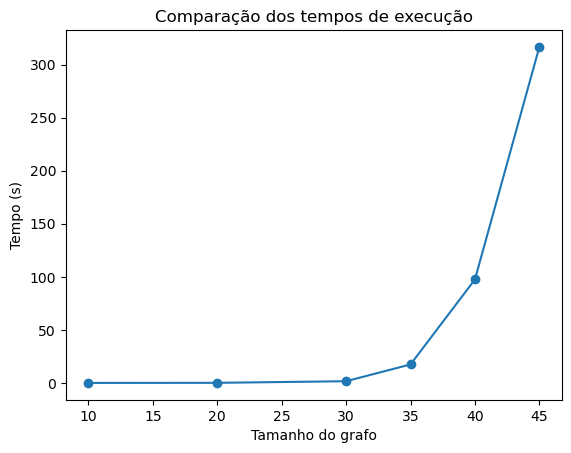

In [2]:
import matplotlib.pyplot as plt

tempos = [0.000436779, 0.085726, 1.60287, 17.4298, 97.4898, 316.634]
tamanhos = [10, 20, 30, 35, 40, 45]

# plot o gráfico de comparação dos tempos
plt.plot(tamanhos, tempos, 'o-')
plt.xlabel('Tamanho do grafo')
plt.ylabel('Tempo (s)')
plt.title('Comparação dos tempos de execução')
plt.show()

Como podemos ver no gráfico acima, o tempo de execução cresce exponencialmente com o número de vértices do grafo. Para grafos de 45 vértices, o tempo de execução é de aproximadamente 316s, o que é um tempo muito alto para a resolução do problema. Agora, vamos analisar o tempo de execução para grafos de 10 a 45 vértices com a otimização da poda por limites.

## Heuristica com Poda por Limites

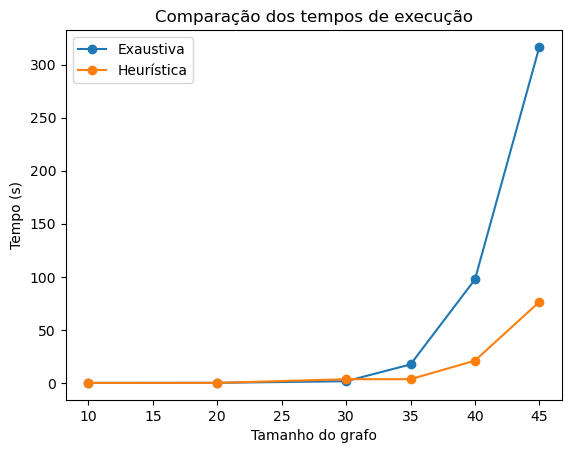

In [3]:
tempos_heuristica = [4.0122e-05, 0.0660059, 3.49519, 3.52743, 20.9961, 76.4163]

# plot o gráfico com 2 curvas de comparação dos tempos
plt.plot(tamanhos, tempos, 'o-', label='Exaustiva')
plt.plot(tamanhos, tempos_heuristica, 'o-', label='Heurística')
plt.xlabel('Tamanho do grafo')
plt.ylabel('Tempo (s)')
plt.title('Comparação dos tempos de execução')
plt.legend()
plt.show()

Agora comparando os dois acima, podemos ver a importância de otimizar os códigos sempre que possível,  o código otimizado apresentou um resultado muito melhor nos grafos com muitos vértices. Vamos agora comparar com os resultados usando OpenMP.

## OpenMP

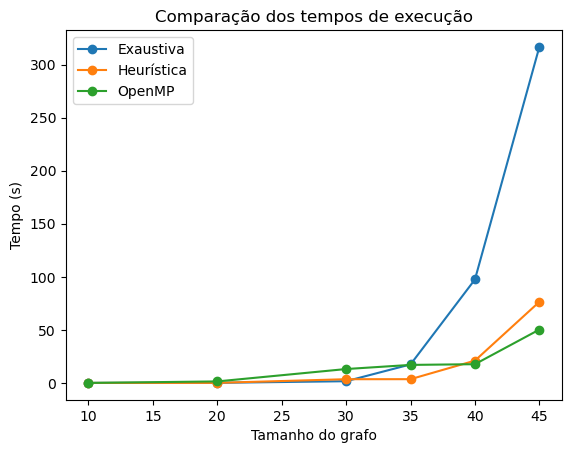

In [4]:
tempos_openmp = [0.00148244, 1.41971, 13.0829, 16.9762, 17.6452, 50.2745]

# plot o gráfico com 3 curvas de comparação dos tempos
plt.plot(tamanhos, tempos, 'o-', label='Exaustiva')
plt.plot(tamanhos, tempos_heuristica, 'o-', label='Heurística')
plt.plot(tamanhos, tempos_openmp, 'o-', label='OpenMP')
plt.xlabel('Tamanho do grafo')
plt.ylabel('Tempo (s)')
plt.title('Comparação dos tempos de execução')
plt.legend()
plt.show()

Podemos ver ao realizar esta comparação que para grafos com poucos vértices, o tempo de execução é maior que o tempo de execução da implementação exaustiva, porém, para grafos com muitos vértices, o tempo de execução é muito menor, o que mostra que a implementação com OpenMP é mais eficiente que a implementação exaustiva. Nos grafos pequenos, esse aumento de tempo pode ser explicado pelo overhead de criação das threads, que é maior que o tempo de execução da implementação exaustiva. Vamos agora comparar com os resultados usando MPI.

## MPI

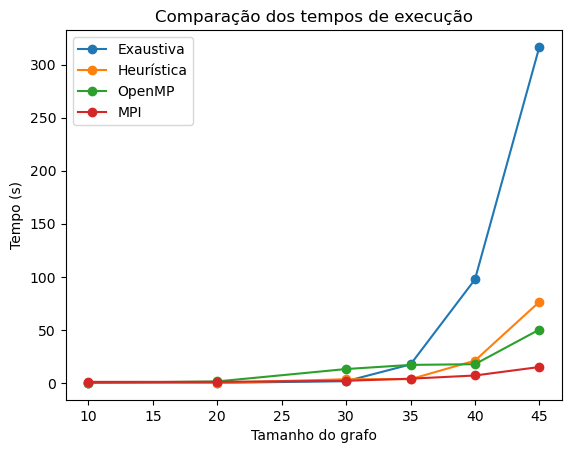

In [5]:
mpi_tempos = [1, 1, 2, 4, 7, 15]

# plot o gráfico com 4 curvas de comparação dos tempos
plt.plot(tamanhos, tempos, 'o-', label='Exaustiva')
plt.plot(tamanhos, tempos_heuristica, 'o-', label='Heurística')
plt.plot(tamanhos, tempos_openmp, 'o-', label='OpenMP')
plt.plot(tamanhos, mpi_tempos, 'o-', label='MPI')
plt.xlabel('Tamanho do grafo')
plt.ylabel('Tempo (s)')
plt.title('Comparação dos tempos de execução')
plt.legend()
plt.show()

# Conclusão

Como podemos ver, a implementação com MPI foi a mais eficiente, pois apresentou o menor tempo de execução para todos os grafos testados. Isso se deve ao fato de que a implementação com MPI divide o problema em várias partes e distribui o processamento entre os processadores, enquanto as outras implementações não fazem isso. A implementação com OpenMP também foi mais eficiente que a implementação exaustiva, pois divide o problema em várias threads, porém, não distribui o processamento entre os processadores, o que faz com que o tempo de execução seja maior que o da implementação com MPI.
O MPI e OpenMP seriam até capazes de resolver o problema para grafos maiores, mas como o escopo do projeto foca na comparação de desempenho entre as implementações, não foi realizado o teste para grafos maiores. Outra possibilidade seria alterar a quantidade de núcleos de processamento utilizados e comparar os resultados. Ou até mesmo implementar uma versão híbrida, que utiliza MPI e OpenMP, para comparar os resultados com as outras implementações.

## Códigos-fonte de apoio

#### Códigos fornecidos pelos professores para auxiliar na implementação


1. Código-fonte de geração do grafo (em Python)


```python

import networkx as nx
import random

# Parâmetros
num_vertices = 1000  # Número de vértices no grafo
probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

# Crie um grafo aleatório densamente conectado
grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

# Nome do arquivo de saída
nome_arquivo = "grafo.txt"

# Abra o arquivo para escrita
with open(nome_arquivo, 'w') as arquivo:
    # Escreva a quantidade de vértices e número de arestas na primeira linha
    arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

    # Escreva as arestas no formato de lista de adjacência
    for aresta in grafo.edges():
        arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")

```


2. Trecho de código-fonte para leitura do grafo e armazenamento como matriz de adjacência

```cpp
// Função para ler o grafo a partir do arquivo de entrada
std::vector<std::vector<int>> LerGrafo(const std::string& nomeArquivo, int& numVertices) {
    std::ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    std::vector<std::vector<int>> grafo(numVertices, std::vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();

    return grafo;
}
```

3. Verificar (em Python) se seu programa encontrou a clique correta. Para isso, use a implementação abaixo, ela já está adaptada para ler nosso arquivo de input, ignorando a primeira linha.


```python
import networkx as nx

# Nome do arquivo de entrada
nome_arquivo = "seu_arquivo.txt"

# Abrir o arquivo e pular a primeira linha
with open(nome_arquivo, 'r') as arquivo:
    next(arquivo)  # Pula a primeira linha

    # Lê o grafo a partir das linhas restantes
    G = nx.parse_adjlist(arquivo)

# Encontrar todas as cliques maximais
cliques_maximais = list(nx.find_cliques(G))

# Encontrar a clique máxima (a maior)
clique_maxima = max(cliques_maximais, key=len)

print("Cliques maximais encontradas:")
for clique in cliques_maximais:
    print(clique)

print("Clique máxima encontrada:", clique_maxima)


```


# Referências

- https://www.mpi-forum.org/docs/
- https://www.openmp.org/
- https://dl.acm.org/doi/abs/10.1145/2043652.2043654